In [31]:
import pandas as pd 
import numpy as np 
from scipy.signal import csd
import networkx as nx 
import matplotlib.pyplot as plt
import datetime 
from numpy.linalg import inv
import itertools
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.PCUtils.BackgroundKnowledgeOrientUtils import \
    orient_by_background_knowledge

In [32]:
covid_data= pd.read_csv("data/us.csv")
n_rows = len(covid_data)

daily_case_avg = np.zeros(n_rows)
daily_death_avg = np.zeros(n_rows)
for i in range(n_rows):
    case = 0
    deaths = 0 
    if(i == 0):
        continue
    elif(i < 7):
        case  = np.mean(covid_data["cases"][:i])
        deaths = np.mean(covid_data["deaths"][:i])
    else:
        case  = np.mean(covid_data["cases"][i-7:i])
        deaths = np.mean(covid_data["deaths"][i-7:i])     
    daily_case_avg[i] = case 
    daily_death_avg[i] = deaths 
covid_data["daily_death"] = covid_data["deaths"] - daily_death_avg
covid_data["daily_case"] = covid_data["cases"] - daily_case_avg


In [33]:
covid_data

,date,cases,deaths,daily_death,daily_case
0,2020-01-21,1,0,0.000000,1.000000
1,2020-01-22,1,0,0.000000,0.000000
2,2020-01-23,1,0,0.000000,0.000000
3,2020-01-24,2,0,0.000000,1.000000
4,2020-01-25,3,0,0.000000,1.750000
...,...,...,...,...,...
1153,2023-03-19,103784916,1133826,900.000000,113569.714286
1154,2023-03-20,103794703,1133964,772.571429,88109.142857
1155,2023-03-21,103813076,1134177,715.142857,71710.000000
1156,2023-03-22,103864888,1134913,1184.428571,89007.142857


In [34]:
covid_data["deaths"][130] - covid_data["deaths"][129]

963

In [35]:
covid_data["daily_death"][130]

4243.142857142855

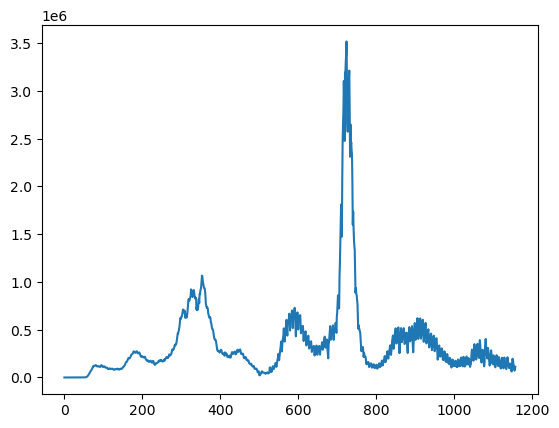

In [36]:
plt.plot(covid_data["daily_case"])
#plt.plot(covid_data["deaths"])

In [37]:
have_ran = True 
def dateNum(date):
    m_day = datetime.date(2022,6,2)
    parts = date.split("-")
    day = datetime.date(int(parts[0]),int(parts[1]),int(parts[2]))
    return (m_day - day).days
if not have_ran:
    tweets = pd.read_csv("data/tweetid_userid_keyword_sentiments_emotions_United States.csv")
    tweets["emotion"] = tweets["emotion"].fillna("N")
    tweets_data = dict() 
    def convertor(x):
        if(x in [-2,-1,0,1,2]):
            return [-2,-1,0,1,2].index(x)
        elif(x in ["N", "S", "H", "A","F"]):
            return ["N", "S", "H", "A","F"].index(x)+5
        else:
            print("Oh no this shound't happen at ", x )
            

    for i in range(n_tweets):
        day = tweets["tweet_timestamp"][i].split(" ")[0]
        sent = tweets["sentiment"][i] 
        emote = tweets["emotion"][i] 
        if(day in tweets_data):
            tweets_data[day][convertor(sent)] += 1
            tweets_data[day][convertor(emote)] += 1
        else: 
            arr = [0 for i in range(10)]
            arr[convertor(sent)] = 1 
            arr[convertor(emote)] = 1
            tweets_data[day] = arr.copy() 
    n = len(tweets_data)
    dates = ["" for i in range(n)] 


    measurement = np.zeros((n, 10))

    for tweet in tweets_data:
        i = dateNum(tweet)
        measurement[i, :] = tweets_data[tweet]
        dates[i] = tweet 
    twitter_cleaned = pd.DataFrame(measurement,
                                columns=["-2_sent","-1_sent","0_sent",
                                            "1_sent","2_sent",
                                            "N", "S", "H", "A","F"] )
    twitter_cleaned.insert(0, "Date", dates)
    twitter_cleaned.to_csv("data/twitter_aggr.csv")
else: 
    twitter_data = pd.read_csv("data/twitter_aggr.csv")

In [38]:
emotions = ["N", "S", "H", "A", "F"]
sents = ["-2_sent", "-1_sent", "0_sent", "1_sent", "2_sent"]

In [178]:
def filter_foo(val, data):
    if(val > np.mean(data)):
        return 1 
    else: 
        return 0
    # if(val < np.quantile(data, 0.25)):
    #     return 1 
    # elif(val < np.quantile(data, 0.5)):
    #     return 2 
    # elif(val < np.quantile(data, 0.75)):
    #     return 3 
    # else:
    #     return 4

def average_sent(row):
    weights = [-2, -1, 0, 1, 2]
    labels = ["-2_sent", "-1_sent", "0_sent", "1_sent", "2_sent"]
    total = sum( weights[i]*row[labels[i]] for i in range(5))
    return round(total)
#keys =  {0 : "-2_sent", 1 : "-1_sent", 2 : "0_sent", 3 : "1_sent", 4 : "2_sent" 
 #        ,7 : "A", 8 : "H", 9 : "S", 10 : "N", 11 : "F"}
keys_emote = {0 : "A", 1 : "H", 2 : "S", 3 : "N", 4 : "F" }
keys_sent = {0 : "-2_sent", 1: "-1_sent", 2:"0_sent", 3:"1_sent", 4:"2_sent"}
n = len(keys_emote)+2
data = np.zeros((n,len(twitter_data["A"])))
emote_data =  np.zeros((n,len(twitter_data["A"])))
sent_data =  np.zeros((n,len(twitter_data["A"])))
emote_dis = np.zeros((n, len(twitter_data["A"])))
sent_dis = np.zeros((n, len(twitter_data["A"])))

totals = np.sum(twitter_data[["A","S","F","H","N"]], axis=1)
total_sent = [average_sent(twitter_data.iloc[i]) for i in range(len(twitter_data["A"]))][::-1]
for i in range(n):
    if(i==5):
        emote_data[i,:] = covid_data["daily_case"][7:864]
        sent_data[i,:] = covid_data["daily_case"][7:864]

        emote_dis[i,:] = [filter_foo(val,
                                covid_data["daily_case"][7:864]) for val in covid_data["daily_case"][7:864]]
        sent_dis[i,:] = [filter_foo(val,
                                covid_data["daily_case"][7:864]) for val in covid_data["daily_case"][7:864]]
        #emote_dis[i+7, :] = [filter_foo(val, covid_data["daily_cases"][7:864]) for val in covid_data["daily_cases"][7:864].rolling(7).sum().fillna(0)]

    elif(i==6):
        emote_data[i,:] = covid_data["daily_death"][7:864]
        sent_data[i,:] = covid_data["daily_death"][7:864]

        emote_dis[i,:] = [filter_foo(val,
                                covid_data["deaths"][7:864]) for val in covid_data["deaths"][7:864]]
        sent_dis[i,:] = [filter_foo(val,
                                covid_data["daily_death"][7:864]) for val in covid_data["daily_death"][7:864]]
        #remote_dis[i+7, :] = [filter_foo(val, covid_data["daily_death"][7:864]) for val in covid_data["daily_death"][7:864].rolling(7).sum().fillna(0)]

    # "elif(i==7):
    #    emote_dis[i, :] = [filter_foo(val, np.sum(twitter_data[["A","F","S","N","H"]],axis=1)) for val in np.sum(twitter_data[["A","F","S","N","H"]][::-1],axis=1)]"

    else: 
        emote_data[i,:] = twitter_data[keys_emote[i]][::-1]
        sent_data[i,:] = twitter_data[keys_sent[i]][::-1]
        emote_dis[i,:] = [filter_foo(val,
                                twitter_data[keys_emote[i]]) for val in twitter_data[keys_emote[i]][::-1]]
        sent_dis[i,:] = [filter_foo(val,
                                twitter_data[keys_sent[i]]) for val in twitter_data[keys_sent[i]][::-1]]
        
        #emote_dis[i+7, :] = [filter_foo(val, twitter_data[keys_emote[i]]) for val in twitter_data[keys_emote[i]][::-1].rolling(7).sum().fillna(0)]

df_emote_dis = pd.DataFrame(emote_dis.T, columns=["A", "S", "F", "H","N","sick","deaths"])

In [179]:
np.sum(twitter_data[["A","F","S","N","H"]],axis=1)

0       8058.0
1      25473.0
2      26312.0
3      20050.0
4      20173.0
        ...   
852    10454.0
853    14333.0
854    15063.0
855    14628.0
856     9327.0
Length: 857, dtype: float64

In [180]:
def insert_diag(M):
    n = len(M)
    A = np.zeros((n+1,n+1), dtype=np.complex64)
    for i in range(n):
        for j in range(0,i):
            A[i,j] = M[i,j] 
        for j in range(i+1, n+1):
            A[i,j] = M[i, j-1]
    return A 
### 60 is an arbitrary frequency to check
def wiener_project(csd_data, freq=60):
    n = len(csd_data)
    result = np.zeros((n,n), dtype=complex)
    for i in range(n):
        mxx = np.zeros((n-1,n-1), dtype=np.complex64)
        c = 0 
        for j in range(n):
            if(j==i): continue
            d = 0
            for k in range(n):
                if(k==i): continue
                mxx[c,d] = csd_data[j,k,freq]
                d += 1
            c += 1 
        fil = [j for j in range(n) if j!=i]

        result[i, fil] =  csd_data[i,fil,freq] @ inv(mxx)
    return result



In [181]:
def adj(data, i, ex=-1):
    lst = []
    for j in range(6):
        if(j == ex or j == i):
            continue
        if(data[i,j] == 1):
            lst.append(j)
    return lst 

def max_adj(data):
    adjs = np.sum(data, axis=0)
    return np.max(adjs) 

def project(csd_data, data, i, subspace_idx,freq=45):
    n = len(subspace_idx)
    v =   csd_data[i, subspace_idx]
    M = np.zeros((n,n), np.complex64)
    for j in range(n):
        for k in range(n):
            M[j,k] = csd_data[subspace_idx[j], subspace_idx[k]]
    Minv = inv(M)
    return v @ Minv @ data[:, subspace_idx].T



def seps(csd_data, data , x : int ,y : int , subset : list ):
    xz = project(csd_data, data, x, subset)
    xyz = project(csd_data, data, x, [y] + subset )
    return np.linalg.norm( xyz - xz) < 350 ## not sure if it should be properly 0 or just small 

def pc1(csd_data,data): 
    n = len(data)
    G1 = np.ones((n,n)) - np.eye(n,n)
    seperators = {}
    depth = 0
    while(max_adj(G1) >= depth ): 
        for x in range(n):
            for y in range(n):
                if(G1[x,y] == 0): continue 
                if(sum(G1[x,:]) - 1 >= depth ): 
                    lst = adj(G1, x, y)
                    for s in itertools.combinations(lst, depth):
                        if(seps(csd_data,data, x, y, list(s))):
                            G1[x,y] = 0 
                            G1[y,x] = 0
                            seperators[(x,y)] = s
                            seperators[(y,x)] = s
        depth = depth + 1 
    ### using 2 for later parts to denote the edge is of an undirected type
    return G1, seperators 

import copy


## check if orienting j -> i makes an immortality 
def immoral_check(G, i, j):
    n = len(G)
    for a in range(n):
        ## cond: j -> i <- a and not j - a
        if(G[a,i] == 1 and ( G[a,j]==0 and G[j,a]==0 )):
            return True 
    return False 

def pc2(G1, sepers):
    n = len(G1)
    G2 = copy.deepcopy(G1)
    for i in range(n):
        for j in range(n):
            if(i==j):continue
            for k in range(n):
                if(j==k or i==k):continue
                if(G1[i,j] and G1[j,k] and not G1[i,k]):
                    if(j not in sepers[(i,k)]): 
                        G2[i,j] = G2[k,j] = 1 
                        G2[j,i] = G2[j,k] = 0 
    for i in range(n):
        for j in range(n):
            ## Edge is undirected
            if(G2[i,j] == 2):
                if(immoral_check(G2,i,j)):
                    G2[i,j] = 1 
                    G2[j,i] = 0 
    return G2 


In [182]:
# n1 = GraphNode('5')
# n2 = GraphNode('6')
# bk = BackgroundKnowledge().add_required_by_node(n1,n2)
#g_emote_dis, _ = fci(emote_dis.T, background_knowledge=bk)
g_emote_dis, e = fci(emote_dis.T, alpha=0.05) 

g_emote, _ = fci(emote_data.T)
g_sent, _ = fci(sent_data.T)
g_sent_dis, _ = fci(sent_dis.T)
res_emote_dis = GraphUtils.to_pydot(g_emote_dis, labels=["Angry", "Happy", "Sad", "Neutral", "Fear", "Infection", "Death"
                                                         ])
res_emote  = GraphUtils.to_pydot(g_emote, labels=["Angry", "Happy", "Sad", "Neutral", "Fear", "Infection", "Death"])
res_sent_dis  = GraphUtils.to_pydot(g_sent_dis, labels=["-2","-1","0","1","2", "Infection", "Death"])
res_sent  = GraphUtils.to_pydot(g_sent, labels=["-2","-1","0","1","2", "Infection", "Death"])

res_emote_dis.write_png('results/emote_test_dis.png')
res_emote.write_png('results/emote_test.png')
res_sent_dis.write_png('results/sent_test_dis.png')
res_sent.write_png('results/sent_test.png')


  0%|          | 0/7 [00:00<?, ?it/s]

X1 --> X5
X4 --> X2
X2 --> X5
X3 --> X7


  0%|          | 0/7 [00:00<?, ?it/s]

X2 --> X4


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [183]:
# n1 = GraphNode('5')
# n2 = GraphNode('6')
# bk = BackgroundKnowledge().add_required_by_node(n1,n2)
g_emote_dis = pc(emote_dis.T)
g_emote = pc(emote_data.T)
g_sent = pc(sent_data.T)
g_sent_dis = pc(sent_dis.T)
res_emote_dis = GraphUtils.to_pydot(g_emote_dis.G, labels=["Angry", "Happy", "Sad", "Neutral", "Fear", "Infection", "Death"])
res_emote  = GraphUtils.to_pydot(g_emote.G, labels=["Angry", "Happy", "Sad", "Neutral", "Fear", "Infection", "Death"])
res_sent_dis  = GraphUtils.to_pydot(g_sent_dis.G, labels=["-2","-1","0","1","2", "Infection", "Death"])
res_sent  = GraphUtils.to_pydot(g_sent.G, labels=["-2","-1","0","1","2", "Infection", "Death"])

res_emote_dis.write_png('results/emote_test_dis_pc.png')
res_emote.write_png('results/emote_test_pc.png')
res_sent_dis.write_png('results/sent_test_dis_pc.png')
res_sent.write_png('results/sent_test_pc.png')

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

## Regression

In [105]:
def get_splits(split=0.8):
    train_set = []
    test_set = []
    split = 0.8
    for i in range(857):
        coin = np.random.random()
        if(coin < split):
            train_set.append(i)
        else:
            test_set.append(i)
    return train_set, test_set


In [50]:
from sklearn.linear_model import LogisticRegression

In [58]:
clf = LogisticRegression(random_state=0).fit(df_emote_dis[["A","H"]].iloc[train_set], df_emote_dis["F"].iloc[train_set])
clf.score(df_emote_dis[["A","H"]].iloc[test_set], df_emote_dis["F"].iloc[test_set])

0.9421052631578948

In [64]:
clf = LogisticRegression(random_state=0).fit(df_emote_dis[["A","sick"]].iloc[train_set], df_emote_dis["deaths"].iloc[train_set])
clf.score(df_emote_dis[["A","sick"]].iloc[test_set], df_emote_dis["deaths"].iloc[test_set])

0.8

In [95]:
keys = ["A", "H", "S", "N", "F", "sick", "deaths"]
predictors = {"A" : [], "H" : [], "S" : [], "N" : [], "F" : [], "sick":[], "deaths":[]}
for i in range(7):
    for j in range(7):
        if(g_emote_dis.graph[i,j] == -1 and g_emote_dis.graph[j,i] == 1):
            predictors[keys[j]].append( keys[i])


In [102]:
shifted_back = np.zeros(emote_dis.shape)
shifted_back[:, 1:] = emote_dis[:, 0:856]
shifted_back = pd.DataFrame(shifted_back.T, columns=["A", "S", "F", "H","N","sick","deaths"])

In [123]:
n_rounds = 20 
relations = ["H", "F", "deaths"]
accuracies = [0,0,0]
for i in range(20):
    for j in range(3):
        train_set, test_set = get_splits(.7)
        r = relations[j]
        clf = LogisticRegression(random_state=0).fit(df_emote_dis[predictors[r]].iloc[train_set], df_emote_dis[r].iloc[train_set])
        accuracies[j] += (1/n_rounds) * clf.score(df_emote_dis[predictors[r]].iloc[test_set], df_emote_dis[r].iloc[test_set])

In [124]:
accuracies

[0.8672337427437752, 0.9360467341943575, 0.760096704969958]

In [135]:
x = ('S',) 
list(x)
df_emote_dis[list(x)]

,S
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
852,0.0
853,0.0
854,0.0
855,0.0


In [141]:
all_acc = dict()
keys = ["A", "S", "F", "H","N","sick","deaths"]
for j in range(7):
        r = keys[j]
        possible = [k for k in keys if r!=k]
        for s in itertools.combinations(possible, 1):
                ls = list(s)
                acc = 0 
                for i in range(20):
                        train_set, test_set = get_splits()
                        clf = LogisticRegression(random_state=0).fit(shifted_back[ls].iloc[train_set], df_emote_dis[r].iloc[train_set])
                        acc += (1/n_rounds) * clf.score(shifted_back[ls].iloc[test_set], df_emote_dis[r].iloc[test_set])
                name = r + "," + ls[0]
                all_acc[name] = acc
        for s in itertools.combinations(possible, 2):
                ls = list(s)
                acc = 0 
                for i in range(20):
                        train_set, test_set = get_splits()
                        clf = LogisticRegression(random_state=0).fit(shifted_back[ls].iloc[train_set], df_emote_dis[r].iloc[train_set])
                        acc += (1/n_rounds) * clf.score(shifted_back[ls].iloc[test_set], df_emote_dis[r].iloc[test_set])
                name = ",".join([r, ls[0], ls[1]])
                all_acc[name] = acc 


In [142]:
all_acc

{'A,S': 0.7709205443020208,
 'A,F': 0.9061058622154412,
 'A,H': 0.8615719831967757,
 'A,N': 0.9003788546462677,
 'A,sick': 0.5699113001565979,
 'A,deaths': 0.7869799364190224,
 'A,S,F': 0.9024987756696213,
 'A,S,H': 0.8741499832130293,
 'A,S,N': 0.8965614924821467,
 'A,S,sick': 0.7824652921730597,
 'A,S,deaths': 0.7957545798761025,
 'A,F,H': 0.9106956044077039,
 'A,F,N': 0.8941009447716105,
 'A,F,sick': 0.9081564404214026,
 'A,F,deaths': 0.9086176459000078,
 'A,H,N': 0.9089233706160942,
 'A,H,sick': 0.8746936225317044,
 'A,H,deaths': 0.8689390482197731,
 'A,N,sick': 0.9014398726541832,
 'A,N,deaths': 0.8985844993111507,
 'A,sick,deaths': 0.7959170528505408,
 'S,A': 0.7995782120612318,
 'S,F': 0.8257598239661301,
 'S,H': 0.8362995346795198,
 'S,N': 0.7693344743632942,
 'S,sick': 0.5376464168685885,
 'S,deaths': 0.7513260258532082,
 'S,A,F': 0.8177837819362177,
 'S,A,H': 0.8412932894593601,
 'S,A,N': 0.8044777539776701,
 'S,A,sick': 0.785918087857789,
 'S,A,deaths': 0.7906976492435647,
 

In [153]:
for i in range(11):
    print(e[i].node1, e[i].node2, e[i].properties)

X1 X2 []
X1 X3 []
X1 X4 []
X1 X5 [<Property.dd: 1>, <Property.nl: 2>]
X4 X2 [<Property.dd: 1>, <Property.nl: 2>]
X2 X5 [<Property.dd: 1>, <Property.nl: 2>]
X3 X4 []
X6 X3 []
X3 X7 [<Property.dd: 1>, <Property.nl: 2>]
X4 X7 []
X6 X7 [<Property.pd: 3>, <Property.pl: 4>]


In [154]:
["Angry", "Happy", "Sad", "Neutral", "Fear", "Infection", "Death"]

['Angry', 'Happy', 'Sad', 'Neutral', 'Fear', 'Infection', 'Death']